# Model training in train set and prediction in validation set

reference link: https://wandb.ai/manan-goel/gnn-recommender/reports/Recommending-Amazon-Products-using-Graph-Neural-Networks-in-PyTorch-Geometric--VmlldzozMTA3MzYw

In [ ]:
pip install torch_geometric

In [ ]:
pip install pyvis

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric import utils
import torch_geometric as pyg
from tqdm.auto import tqdm
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from pyvis.network import Network
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import accuracy_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### creating a sample set for model

In [6]:
# using 10000 nodes
graph = torch.load('/content/drive/MyDrive/Graph /amazon0302.pt')
mask = np.zeros(graph.x.shape[0])
mask[:10000] = 1
mask = torch.tensor(mask == 1)
g = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
torch.save(g, '/content/drive/MyDrive/Graph /model_graph.pt')

In [ ]:
# Create a PyVis network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add nodes and edges to the PyVis network
for e in g.edge_index.T:
    src = e[0].item()
    dst = e[1].item()
    net.add_node(src)
    net.add_node(dst)
    net.add_edge(src, dst, value=0.1)
# Save the PyVis visualization to an HTML file
net.save_graph('/content/drive/MyDrive/Graph /model_graph.html')

### splitting the sample dataset into the training and validation set

In [7]:
#using RandomLinkSplit to split the graph nodes
graph = torch.load('/content/drive/MyDrive/Graph /model_graph.pt')
transform = RandomLinkSplit(num_val=0.1, num_test=0, split_labels=True)
train_data, val_data, test_data = transform(graph)

torch.save(train_data, '/content/drive/MyDrive/Graph /train.pt')
torch.save(val_data, '/content/drive/MyDrive/Graph /val.pt')

### Define the GNN model and link predictor

In [8]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GNN, self).__init__()

        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers



        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        print(f"Input Shape: {x.shape}")
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)
        print(f"Output Shape: {x.shape}")

        return x

In [9]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

### Train the model and output training loss

In [10]:
# the training data
train_graph = torch.load('/content/drive/MyDrive/Graph /train.pt')
# the setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
hidden_dim = 1024
dropout = 0.1
num_layers = 2
lr = 1e-5
node_emb_dim = 1
batch_size = 1024

train_graph = train_graph.to(device)

In [11]:
# the graph neural network that takes all the node embeddings as inputs to message pass and agregate
model = GNN(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

In [12]:
# define the train function
def train(model, link_predictor, x, edge_index, pos_train_edge, batch_size, optimizer):
    model.train()
    link_predictor.train()

    train_losses = []

    for edge_id in tqdm(pyg.loader.DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True), leave=True):
        optimizer.zero_grad()

        # Run message passing on the initial node features to get updated embeddings
        node_emb = model(x, edge_index)

        # Positive edges
        pos_edge = pos_train_edge[edge_id].T
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])

        # Negative edges sampling
        neg_edge = negative_sampling(edge_index, num_nodes=x.shape[0], num_neg_samples=edge_id.shape[0], method='dense')
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    return train_losses

In [13]:
# define the optimizer
optimizer = torch.optim.Adam(list(model.parameters()) + list(link_predictor.parameters()), lr=lr, weight_decay=optim_wd)

In [14]:
# Training loop
num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = train(
        model,
        link_predictor,
        torch.tensor(train_graph.x).to(torch.float32).to(device),
        train_graph.edge_index,
        train_graph.pos_edge_label_index.T,
        batch_size,
        optimizer
    )
    train_losses.extend(epoch_loss)

    if epoch % 10 == 0:
        node_emb = model(torch.tensor(train_graph.x).to(torch.float32).to(device), train_graph.edge_index)
        pos_edge = train_graph.pos_edge_label_index.T
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])
        print(f"Epoch {epoch}, Shape of node_emb: {node_emb.shape}, Shape of pos_pred: {pos_pred.shape}")

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

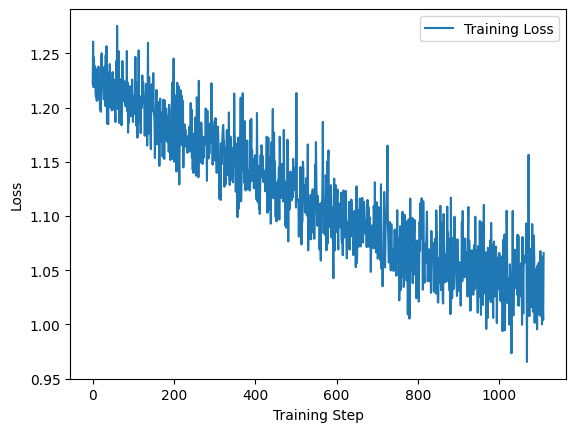

In [ ]:
# Plotting the training losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

### accuracy and prediction in validation set

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_graph = torch.load('/content/drive/MyDrive/Graph /val.pt')
val_graph = val_graph.to(device)

In [16]:
def validate(model, link_predictor, x, edge_index, pos_val_edge, batch_size, max_steps=None):
    model.eval()
    link_predictor.eval()

    val_losses = []
    predictions = []
    ground_truth_labels = []

    # Determine the number of steps for validation
    num_steps = min(len(pos_val_edge), max_steps) if max_steps else len(pos_val_edge)

    if num_steps == 0:
        print("No steps for validation.")
        return val_losses, predictions, ground_truth_labels

    for step in tqdm(range(num_steps), leave=True):
        edge_id = step % len(pos_val_edge)

        # No need to zero_grad or backpropagate during validation
        with torch.no_grad():
            # Run message passing on the initial node features to get updated embeddings
            node_emb = model(x, edge_index)

            # Positive edges
            pos_edge = pos_val_edge[edge_id].T
            pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])

            # Negative edges sampling (for validation, you might want to use all possible negative edges)
            neg_edge = negative_sampling(edge_index, num_nodes=x.shape[0], num_neg_samples=x.shape[0] - len(pos_val_edge), method='dense')
            neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])

            # Compute the corresponding negative log likelihood loss on the positive and negative edges
            loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

            val_losses.append(loss.item())

            # Store predictions and ground truth labels for later evaluation
            predictions.extend(torch.sigmoid(pos_pred).cpu().numpy().flatten().tolist())
            ground_truth_labels.extend([1] * len(pos_pred))
            predictions.extend(torch.sigmoid(neg_pred).cpu().numpy().flatten().tolist())
            ground_truth_labels.extend([0] * len(neg_pred))

    return val_losses, predictions, ground_truth_labels

In [17]:
max_validation_steps = 50
val_losses, val_predictions, val_ground_truth = validate(
    model,
    link_predictor,
    torch.tensor(val_graph.x).to(torch.float32).to(device),
    val_graph.edge_index,
    val_graph.pos_edge_label_index.T,
    batch_size,
    max_steps=max_validation_steps
)

  0%|          | 0/50 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


<ipython-input-16-1be7d829da77>:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  pos_edge = pos_val_edge[edge_id].T


Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Input Shape:

In [18]:
# Calculate accuracy
val_accuracy = accuracy_score(val_ground_truth, np.round(val_predictions))

# Output validation loss and accuracy
print(f"val Loss: {np.mean(val_losses)}")
print(f"val Accuracy: {val_accuracy}")

val Loss: 1.282436707019806
val Accuracy: 0.0031622317596566524


### using a small graph to show the prediction

In [19]:
#using a small graph
graph = torch.load('/content/drive/MyDrive/Graph /amazon0302.pt')
mask = np.zeros(graph.x.shape[0])
mask[10000:10500] = 1
mask = torch.tensor(mask == 1)

small_graph= Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
small_graph.edge_index = small_graph.edge_index - 10000

In [20]:
#adding metadata
metadata= {}
product_data={}
with open('/content/drive/MyDrive/Graph /amazon-meta.txt', 'r', encoding="utf8") as file:
    for _ in range(2):
        next(file)
    for line in file:
        line = line.strip()
        #i=i+1
        #if i>100:
        #    break
        if line:
            try:
                key, value = map(str.strip, line.split(':', 1))
                product_data[key] = value
            except Exception:  #when only value, no key, then pass
                key=''
                value=''
                pass
            #print(key,',', value)
        else:                                              #An empty line indicates the end of one product's data
            if product_data:
                product_id = product_data.get('Id')
                if product_id:
                    metadata[product_id] = product_data
                product_data = {}                          #Reset the current_product dictionary for the next product

In [21]:

# Initialize PyVis network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
k=0
for e in tqdm(small_graph.edge_index.T):
    k=k+1
    src = e[0].item()
    dst = e[1].item()

    # Get predicted labels for the nodes
    src_predicted_label = val_predictions[src]
    dst_predicted_label = val_predictions[dst]

    # Extract metadata for each node
    src_metadata = metadata.get(str(src), {})
    dst_metadata = metadata.get(str(dst), {})
    if k==1:
        print(src_metadata['group'])
        print(dst_metadata)

    # Add nodes with predicted labels and metadata
    #src_title = f"Node {src}\nPredicted Label: {src_predicted_label:.4f}\n\nMetadata:\n{src_metadata.get('group', 'N/A')}"
    #dst_title = f"Node {dst}\nPredicted Label: {dst_predicted_label:.4f}\n\nMetadata:\n{dst_metadata.get('group', 'N/A')}"
    src_title = f"Node {src}\nMetadata:\n{src_metadata.get('group', 'N/A')}"
    dst_title = f"Node {dst}\nMetadata:\n{dst_metadata.get('group', 'N/A')}"

    net.add_node(src, label=src_title, title=src_title)
    net.add_node(dst, label=dst_title, title=dst_title)

    net.add_edge(src, dst, value=0.1)

# Save the PyVis visualization to an HTML file
net.show("/content/drive/MyDrive/Graph /smaller_graph_with_predictions_and_metadata.html", notebook=False)

  0%|          | 0/470 [00:00<?, ?it/s]

Book
{'Id': '3', 'ASIN': '0486287785', 'title': 'World War II Allied Fighter Planes Trading Cards', 'group': 'Book', 'salesrank': '1270652', 'similar': '0', 'categories': '1', 'reviews': 'total: 1  downloaded: 1  avg rating: 5', '2003-7-10  cutomer': 'A3IDGASRQAW8B2  rating: 5  votes:   2  helpful:   2'}
/content/drive/MyDrive/Graph /smaller_graph_with_predictions_and_metadata.html
